# State preparation example

In this example we will use the generator to find quantum circuit which prepares given probability distribution. 

We compared with Qiskit's "isometry" method, which works faster but outputs deeper circuit with a more CNOT gates. Output of Quantastica's circuit looks less precise, but precision is actually lost during conversion to Qiskit (it is converted to Qiskit and executed for display purposes).


## Prerequisites:

### Install and import Quantastica QPS API

In [1]:
import sys

try:
  from quantastica.qps_api import QPS
except:
  !{sys.executable} -m pip install quantastica-qps-api
  from quantastica.qps_api import QPS

Fore details about quantastica-qps-api package, see: https://pypi.org/project/quantastica-qps-api/


### Register your QPS API key

Uncomment following line, add your API key and run:

In [2]:
# QPS.save_account("YOUR_API_TOKEN")

**WARNING:** Run this only once on your machine and then remove this cell. Don't keep your API key in the notebook for security reasons.

### Helper/utility functions:

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import SVG

from quantastica.qps_api import QPS
from qiskit import QuantumCircuit, QuantumRegister, execute, Aer

import scipy.interpolate as interpolate
import numpy as np

#
# Function converts probability distribution to state vector
# Given vector (of any size and any value range) will be normalized and interpolated to unit vector of size 2**num_qubits
#
def pd_to_sv(pd, num_qubits):
    len_sv = 2**num_qubits

    # get rid of negative values
    min_val = np.min(pd)
    if(min_val < 0):
        pd = [i + np.abs(min_val) for i in pd]
    
    # interpolate to 2**num_qubits if needed
    if(len_sv != len(pd)):
        x = np.arange(0, len(pd))
        f = interpolate.interp1d(x, pd)
        xnew = np.linspace(0, len(pd) - 1, num = int(len_sv))
        pd = f(xnew)

    # normalize sum to 1
    pd = pd / np.sum(pd)
    
    # Make statevector
    pd = np.sqrt(pd).tolist()
    
    # convert to complex
    sv = [complex(i) for i in pd]

    return sv

#
# Function converts back from state vector to probability distribution
# If pd_min and pd_max are given then pdf will be normalized into pd_min...pd_max range
# If pd_len is given then pdf will be interpolated to that length
#
def sv_to_pd(sv, pd_min, pd_max, pd_len):
    pd = np.abs(sv)**2
    
    min_val = np.min(pd)
    max_val = np.max(pd)
    
    pd_min = 0 if pd_min is None else pd_min
    pd_max = 1 if pd_max is None else pd_max
    
    pd = [ (pd_max - pd_min) * ((a - min_val) / (max_val - min_val)) + pd_min for a in pd ]

    if(pd_len):
        x = np.linspace(0, pd_len, pd_len)
        f = interpolate.interp1d(np.linspace(0, pd_len, len(pd)), pd, kind="cubic")
        pd = f(x)
    
    return pd


def plot(arrays):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(1, 1, 1)

    for a in arrays:
        plt.plot(a)

    # show the plot
    plt.show()


def display_circuit(qasm):
    circuit_svg = QPS.converter.convert(qasm, "qasm", "svg-inline")
    display(SVG(circuit_svg))



## Step 1: Define probability distribution

It has to be array of numbers with any length and range. Can be output of any function.

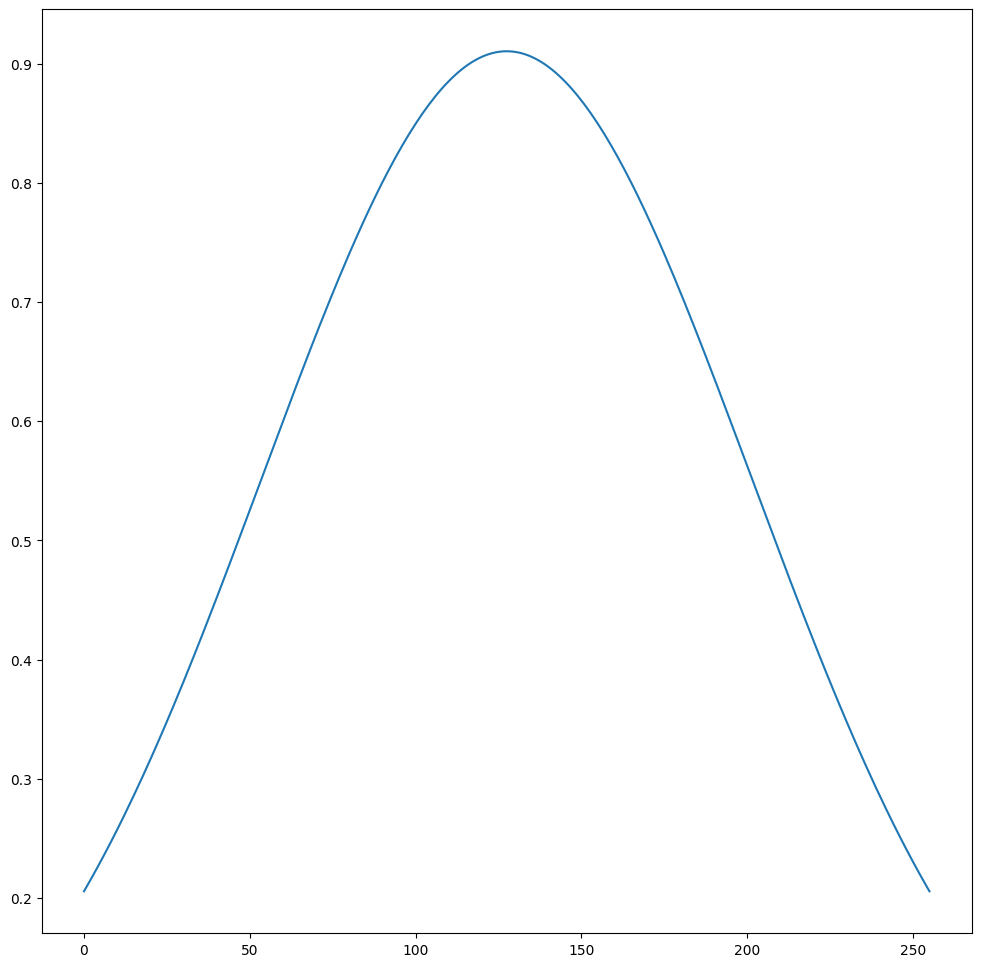

In [4]:
def normal_dist(x):
    mean = np.mean(x)
    sd = np.std(x)
    prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density
 

# Create probability distribution. Can be output of any function
# We are using a normal distribution for example 

input_dist = normal_dist(np.linspace(0,1,256))


num_qubits = 4

target_state = pd_to_sv(input_dist, num_qubits)


# Plot input probability distribution
plot([input_dist])


## Step 3: Using Quantastica generator to prepare state


Depth: 9
Ops: 16
CNOTs: 4


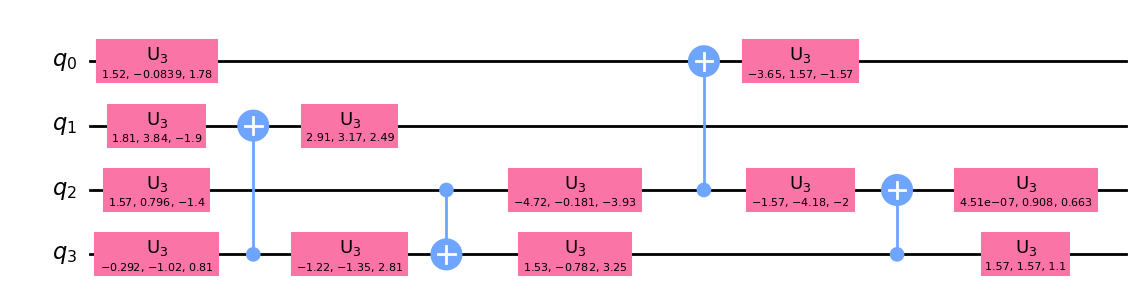

/var/folders/v2/bwdsfywn1md940h7vt3p8p940000gn/T/ipykernel_2419/1808227956.py:30: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(qc, backend=backend)


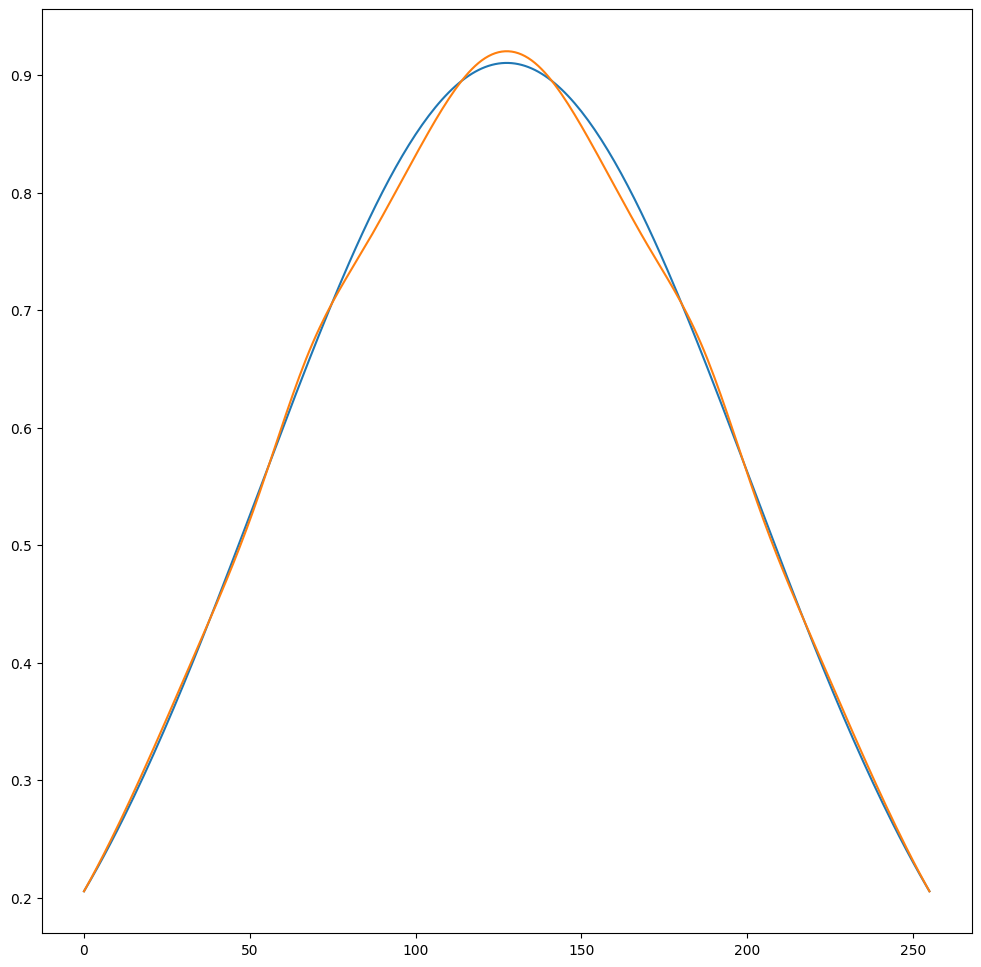

In [12]:
instruction_set = ["u3", "cx"]

job_id = QPS.generator.state_preparation(target_state, settings = { "instruction_set": instruction_set, "max_diff": 0.0005, "pre_processing": "experimental5" })
job = QPS.generator.get_job(job_id, wait=True)
job_status = job["status"]
job_output = job["output"]

if(job_status == "error"):
    raise Exception(job_output["message"])
else:
    if "circuits" not in job_output or len(job_output["circuits"]) == 0:
        raise Exception("No solutions")

resulting_circuit = job_output["circuits"][0]
qasm = resulting_circuit["qasm"]


# To visualize result, we will make Qiskit circuit from returned QASM
qc = QuantumCircuit.from_qasm_str(qasm)

print("")
print("Depth:", qc.depth())
print("Ops:", sum(j for i, j in qc.count_ops().items()))
print("CNOTs:", qc.count_ops()["cx"] if "cx" in qc.count_ops() else 0)

display(qc.draw(output="mpl"))

# Run circuit on state vector simulator
backend = Aer.get_backend("statevector_simulator")
job = execute(qc, backend=backend)
job_result = job.result()

# Read state vector and convert it to pd
output_vector = job_result.get_statevector(qc)
output_dist = sv_to_pd(output_vector, np.min(input_dist), np.max(input_dist), len(input_dist))

plot([input_dist, output_dist])



## Step 4 (Optional) - Transpile to IONQ native instruction set
(this will take about 2-3 minutes...)

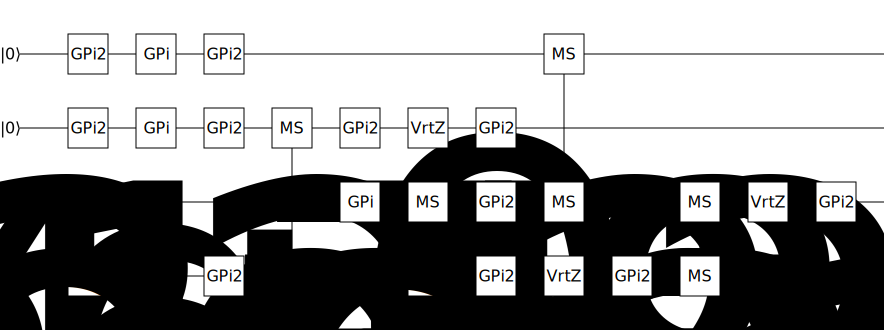

In [13]:
instruction_set = ["gpi", "gpi2", "vz", "ms"]

job_id = QPS.generator.transpile(resulting_circuit["qasm"], method="replace_blocks", method_options={ "block_size": 2, "two_pass": True }, settings = { "instruction_set": instruction_set, "pre_processing": None, "diff_method": "ignorephase" })

job = QPS.generator.get_job(job_id, wait=True)
job_status = job["status"]
job_output = job["output"]
if(job_status == "error"):
    raise Exception(job_output["message"])

if(len(job_output["circuits"]) == 0):
    raise Exception("No solutions")

transpiled_circuit = job_output["circuits"][0]

transpiled_qasm = transpiled_circuit["qasmExt"]

display_circuit(transpiled_qasm)
